# Rhythm triangles and melody squares

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ternary
import h5py

In [2]:
# Settings and global variables
plt.rcParams['font.sans-serif'] = ['Arial', 'HelveticaNeue', 'Helvetica']
CATAFOLK_DIR = '/Users/Bas/surfdrive/catafolk'
DATA_FN = 'data.hdf5'
with h5py.File(DATA_FN, 'r') as file:
    CORPORA = [key for key in file.keys()]

### Utilities

In [3]:
def split_at(array, value):
    """Split an array after every index where it contains `value`."""
    matches = np.isnan(array) if np.isnan(value) else array == value
    splitpoints = np.where(matches)[0] + 1
    if splitpoints[-1] == len(array):
        splitpoints = splitpoints[:-1]
    return np.array_split(array, splitpoints)

In [4]:
def split_at_nan(array, skip_empty=False):
    sections = []
    for section in split_at(array, np.nan):
        if np.isnan(section[-1]):
            section = section[:-1]
        if len(section) > 0 or not skip_empty:
            sections.append(section)
    return sections

# array = np.array([1, 2, np.nan, 4, 5, 6, 7, np.nan, 8, 9, 10, 11, np.nan, 1, np.nan, np.nan, 1])
# split_at_nan(array)

In [5]:
def sliding_window(array, window):
    """Returns a matrix where every row corresponds to a window from the array"""
    if window > len(array):
        return np.array([])
    N = len(array) - window + 1
    repeated_windows = np.tile(np.arange(window), (N, 1)) 
    indices = repeated_windows + np.arange(N)[:, np.newaxis]
    return array[indices]

# intervals = np.array([1, 2, 3, 4, 5, 6])
# sliding_window(intervals, 2)

In [6]:
def interval_motifs(songs, length=2, normalize=False):
    motifs = []
    for song in songs:
        intervals = song[1:] - song[:-1]
        song_motifs = sliding_window(intervals, length)
        motifs.extend(song_motifs)
    motifs = np.array(motifs)

    if not normalize:
        return motifs
    else:
        duration = motifs.sum(axis=1)
        motifs = motifs / duration[:, np.newaxis]
        return motifs, duration

interval_motifs([np.array([2, 3, 5, 9]), np.array([5, 6, 7])], length=2)

array([[1, 2],
       [2, 4],
       [1, 1]])

### Triangle plotting

In [7]:
def subset(motifs, duration, min_dur=0, max_dur=np.inf, limit=-1, shuffle=True):
    """Select a subset of triplets (motifs): select only those motifs whose
    duration is between the minimum and maximum duration (min_dur, max_ddur),
    limit to a certain number of motifs, and optionally shuffle the motifs.
    """
    match = (duration >= min_dur) & (duration <= max_dur)
    index = np.arange(len(motifs))[match]
    if limit == -1 or limit > len(index):
        limit = len(index)
    if shuffle: 
        index = np.random.choice(index, size=limit, replace=False)
    else:
        index = index[:limit]
    if len(index) == 0:
        raise Warning(f'The filter returns no motifs (min_dur={min_dur}, max_dur={max_dur}, limit={limit})')
    return motifs[index, :], duration[index], index

In [8]:
# Styling of rhythm plot
def setup_rhythm_plot(scale, subdiv=4, grid=False, grid_kws={}, label_offset=.05, ax=None):
    if ax is None: ax = plt.gca()
    kws = dict(linestyle=':')
    _grid_kws = dict(
        color='k', linewidth=0.5, 
        left_kwargs=kws, right_kwargs=kws, horizontal_kwargs=kws
    )
    _grid_kws.update(grid_kws)
    multiple = scale / subdiv

    figure, tax = ternary.figure(scale=scale, ax=ax)
    figure.dpi = 150
    ax.axis('equal')
    ax.set_axis_off()
    tax.boundary(linewidth=0.5)
    
    if grid:
        tax.gridlines(multiple=multiple, **_grid_kws)

    if subdiv > 1:
        ticks = [f'{x:.2f}' for x in np.linspace(0, 1, subdiv+1)]
        tax.ticks(axis='lbr', multiple=multiple, offset=.02, lw=0.5, ticks=ticks, fontsize=6)
        label_offset += 0.1
        
    tax.right_axis_label('interval 2', fontsize=7, offset=label_offset)
    tax.left_axis_label('interval 3', fontsize=7, offset=label_offset)
    tax.bottom_axis_label('interval 1', fontsize=7, offset=label_offset)
    return figure, tax

In [9]:
def show_integer_ratios(tax, scale, factors=[1, 2, 3], color='k'):
    from itertools import product
    
    points = dict()
    for a, b, c in product(factors, factors, factors):
        total = a + b + c
        point = (a/total, b/total, c/total)
        if point not in points.keys():
            points[point] = (a, b, c)

    for point, (a, b, c) in points.items():
        point = np.array(point) * scale
        tax.scatter([point], marker='+', s=8, color=color, linewidth=0.25)
        tax.annotate(f'{a}{b}{c}', point, color=color,
            ha='center', va='bottom', fontsize=4.5,
            xytext=(0, 1), textcoords='offset points')

# fig, tax = setup_rhythm_plot(scale=60, subdiv=4, grid=True)
# show_integer_ratios(tax, scale=60, factors=[1, 2, 3, 4])

In [10]:
# Color by cycle duration
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def show_triangle_scatter(motifs, duration, 
        min_dur=0.1, max_dur=0.8, limit=30000, 
        s=1, alpha=.3, jitter=0,
        scale=60, subdiv=1, ratios=True, ratios_kws={}, 
        cmap='plasma_r', colorbar=True, vmin=None, vmax=None, ax=None,
        colorbar_label='duration (quarter)'
    ):
    if ax is None: ax = plt.gca()
    if 0 <= min_dur <= 1: min_dur = np.quantile(duration, min_dur).astype(int)
    if 0 <= max_dur <= 1: max_dur = np.quantile(duration, max_dur).astype(int)
    if vmin is None: vmin = min_dur
    if vmax is None: vmax = max_dur
    norm = Normalize(vmin=vmin, vmax=vmax)

    X, dur, _ = subset(motifs, duration, min_dur=min_dur, max_dur=max_dur, limit=limit)
    X = X + jitter * np.random.normal(0, 1, size=X.shape)
    X *= scale

    fig, tax = setup_rhythm_plot(scale, subdiv, ax=ax)
    tax.scatter(X, s=s, alpha=alpha, c=dur, norm=norm, vmin=None, vmax=None, cmap=cmap, lw=0)
    if colorbar:
        mappable = ScalarMappable(norm=norm, cmap=cmap)
        fig.colorbar(mappable, ax=ax, label=colorbar_label)
    if ratios:
        show_integer_ratios(tax, scale, [1, 2, 3], **ratios_kws)
    return fig, tax

## Rhythm triangles

In [11]:
def load_data(corpus, repeats=False):
    """Load the pitches and onsets for every entry in a corpus. The pitches and
    onsets are both lists of numpy arrays of equal length."""
    with h5py.File(DATA_FN, 'r') as file:
        root = f"{corpus}/{'with' if repeats else 'without'}-repeats/"
        all_onsets = file[f'{root}/onsets'][:]
        all_pitches = file[f'{root}/pitches'][:]
        assert len(all_pitches) == len(all_onsets)

    if len(all_onsets) == 0: return [], []
    onsets = split_at_nan(all_onsets)
    pitches = split_at_nan(all_pitches)
    assert len(onsets) == len(pitches)
    return onsets, pitches

onsets, pitches = load_data(CORPORA[0])

In [12]:
def normalize(motifs):
    duration = motifs.sum(axis=1)
    motifs = motifs / duration[:, np.newaxis]
    return motifs, duration

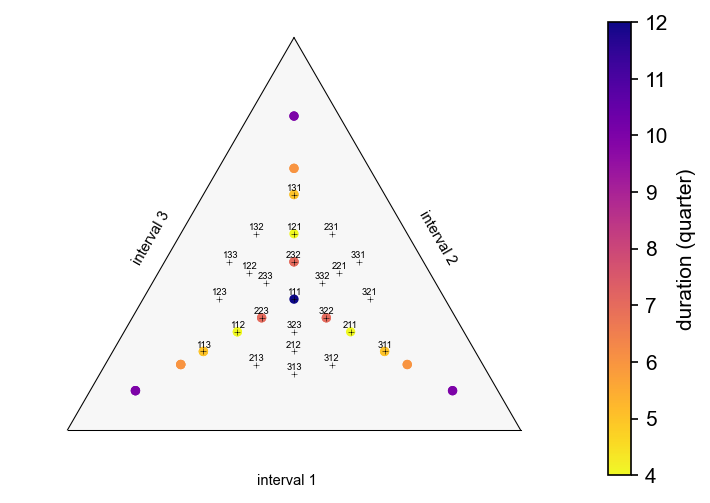

In [13]:
demo_onsets = [
    np.cumsum([0, 1, 1, 2, 1, 1, 2]),
    np.cumsum([0, 4, 4, 4]),
    np.cumsum([0, 1, 1, 3, 1, 1, 3, 1, 1, 3]),
    np.cumsum([0, 1, 1, 4, 1, 1, 4, 1, 1, 4]),
    np.cumsum([0, 1, 1, 8, 1, 1, 8, 1, 1, 8]),
    np.cumsum([0, 2, 3, 2, 2, 3, 2, 2, 3, 2]),
]
motifs, duration = normalize(interval_motifs(demo_onsets, 3))
show_triangle_scatter(motifs, duration, alpha=1, s=20, min_dur=0.0, max_dur=1.0);

In [14]:
# for corpus in CORPORA:
#     onsets, _ = load_data(corpus, repeats=True)
#     if len(onsets) == 0: 
#         print('No onsets for', corpus)
#         continue
#     alpha = 1 if len(onsets) < 50 else 0.3
#     motifs, duration = normalize(interval_motifs(onsets, 3))
#     show_triangle_scatter(
#         motifs, duration, 
#         alpha=.1, s=2, limit=5000, min_dur=0, jitter=0.01
#     )
#     plt.title(f'{corpus}')
#     plt.savefig(f'figures/rhythm-triangle-{corpus}.pdf')
#     plt.close()

## Melody squares

In [15]:
from collections import Counter
from itertools import product

def motif_histogram(motifs, min_value=None, max_value=None, normalize=True):
    if min_value is None: min_value = np.floor(motifs.min())
    if max_value is None: max_value = np.ceil(motifs.max())
    dim = motifs.shape[1]
    counts = Counter([tuple(m) for m in motifs])
    values = np.arange(min_value, max_value+1)
    hist = np.zeros([len(values)] * dim)
    for idx in product(*[np.arange(len(values))]*dim):
        point = tuple([values[i] for i in idx])
        hist[idx] = counts[point]
    if normalize:
        hist = hist / sum(counts.values())
    # Make sure that the first interval is the first axis etc
    hist = hist.T 
    return hist, values

In [16]:
def collect_histograms(corpora=CORPORA, min_value=-7, max_value=7, repeats=False):
    histograms = []
    for corpus in corpora:
        _, pitches = load_data(corpus, repeats=repeats)
        motifs = interval_motifs(pitches, 2)
        if len(motifs) == 0: 
            raise Exception(f'No motifs found for corpus {corpus}')
        hist, values = motif_histogram(motifs, min_value=min_value, max_value=max_value)
        hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
        histograms.append(hist)
    return histograms

In [17]:
# Determine the range of the frequencies
vmin = np.min([h[h>0].min().min() for h in collect_histograms()])
vmax = np.max([h[h>0].max().max() for h in collect_histograms()])
vmin, vmax

(1.356557599435672e-05, 0.14194139194139194)

In [18]:
from matplotlib.colors import LogNorm

def show_melodic_motif_histogram(hist, mask_zero=True, **kwargs):
    _kwargs = dict(cmap='PuRd', cbar=False, ax=plt.gca())
    _kwargs.update(kwargs)
    if mask_zero: _kwargs['mask'] = hist == 0
    ax = _kwargs['ax']
    sns.heatmap(hist, **_kwargs)
    ax.axis('equal')

def plot_melodic_motif_histogram(corpus, repeats=False, range=12, decorate=True, **kwargs):
    _, pitches = load_data(corpus, repeats=repeats)
    motifs = interval_motifs(pitches, 2)
    if len(motifs) == 0: return
    hist, values = motif_histogram(motifs, min_value=-1*range, max_value=range)
    hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
    
    show_melodic_motif_histogram(hist, **kwargs)
    if decorate:
        plt.title(corpus)
        plt.axhline(range+.5, lw=.5, ls='--', c='0.7')
        plt.axvline(range+.5, lw=.5, ls='--', c='0.7')
        plt.xlabel('previous interval (semitones)')
        plt.ylabel('next interval (semitones)')
    else:
        plt.axis('off')

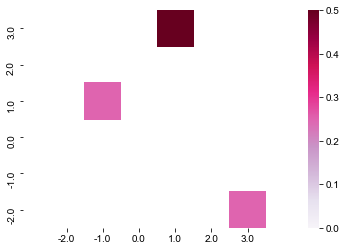

In [19]:
# Dummy data to check plotting works as expected
hist, values = motif_histogram(np.array([[1, 3], [1, 3], [-1, 1], [3, -2]]))
hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
show_melodic_motif_histogram(hist, vmin=0, vmax=None, cbar=True) 

Text(0.5, 1.0, 'Logarithmic color map')

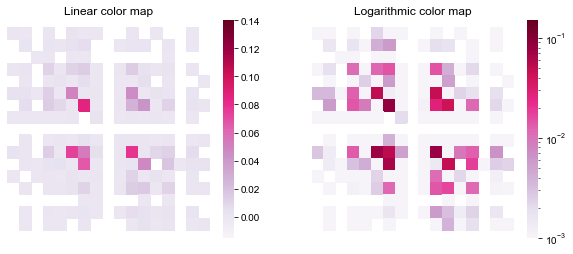

In [20]:
# Linear vs logarithmic color map
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_melodic_motif_histogram('essen-china-han', decorate=False, range=8, vmin=-0.015, vmax=0.14, ax=axs[0], cbar=True)
axs[0].axis('off')
axs[0].set_title('Linear color map')
plot_melodic_motif_histogram('essen-china-han', decorate=False, range=8, norm=LogNorm(vmin=1e-3, vmax=0.15), ax=axs[1], cbar=True)
axs[1].set_title('Logarithmic color map')
# plt.savefig('figures/colorbar.pdf')

In [21]:
# # Small plots
# for corpus in CORPORA:
#     plt.subplots(figsize=(3, 3), tight_layout=True)
#     plot_melodic_motif_histogram(corpus, 
#         repeats=True, 
#         range=8, 
#         norm=LogNorm(vmin=1e-3, vmax=0.15), 
#         decorate=False, 
#     )
#     plt.savefig(f'figures/melody-squares-small/melody-squares-small-{corpus}.pdf')
#     plt.close()

# # For linear color map use vmin=-0.015, vmax=0.14

In [22]:
# # Large plots
# for corpus in CORPORA:
#     plt.subplots(figsize=(6, 6), tight_layout=True)
#     plot_melodic_motif_histogram(corpus, 
#         repeats=True, 
#         range=25, 
#         # Note that the minimum value in this data is 1e-5 (see below)
#         norm=LogNorm(vmin=1e-4, vmax=0.15), 
#     )
#     plt.savefig(f'figures/melody-squares-large/melody-square-large-{corpus}.pdf')
#     plt.close()

### 'Residuals': deviations from global average

In [23]:
def residual_histograms(corpora=CORPORA, **kwargs):
    histograms = collect_histograms(corpora=CORPORA, **kwargs)
    hists = np.array([h.values for h in histograms])
    mean = pd.DataFrame(
        hists.mean(axis=0), 
        index=histograms[0].index, 
        columns=histograms[0].columns)
    residuals = [hist - mean for hist in histograms]
    return mean, residuals

Text(0.5, 1.0, 'Average motif frequencies')

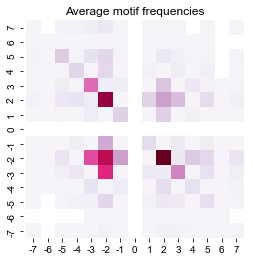

In [24]:
mean, _ = residual_histograms(CORPORA)
plt.figure(figsize=(4, 4))
show_melodic_motif_histogram(mean)
plt.title('Average motif frequencies')

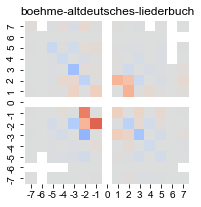

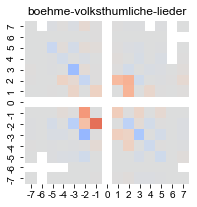

In [25]:
_, residuals = residual_histograms(CORPORA)
for corpus, hist in zip(CORPORA[:2], residuals):
    plt.figure(figsize=(3, 3))
    show_melodic_motif_histogram(hist, cmap='coolwarm', vmin=-.075, vmax=.075)
    plt.title(corpus)
    plt.show()
    

### Clustering traditions

In [26]:
def matrix_pdist(matrices, ord=None):
    dists = np.zeros((len(matrices), len(matrices)))
    for i, df0 in enumerate(matrices):
        for j, df1 in enumerate(matrices):
            if i > j: continue
            dists[i, j] = np.linalg.norm(df0 - df1, ord=ord)
            dists[j, i] = np.linalg.norm(df0 - df1, ord=ord)
    return dists

<AxesSubplot:>

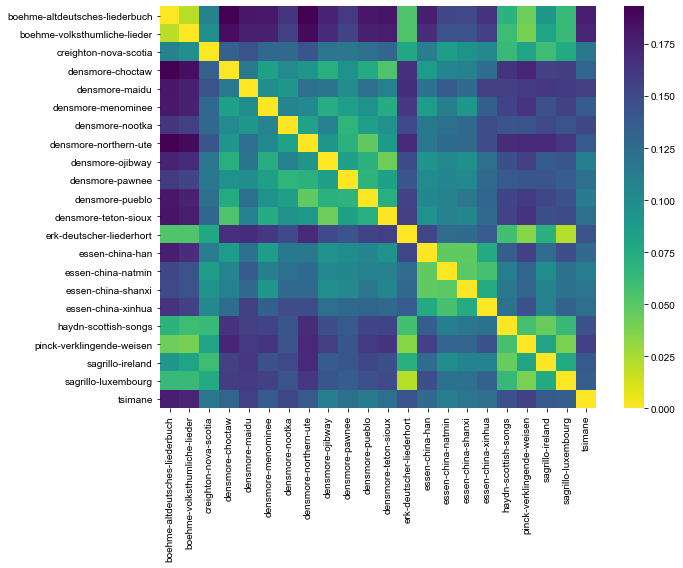

In [27]:
plt.figure(figsize=(10, 8), tight_layout=True)
histograms = collect_histograms(CORPORA, min_value=-12, max_value=12)
dists = matrix_pdist(histograms, ord='fro')
sns.heatmap(dists, xticklabels=CORPORA, yticklabels=CORPORA, cmap='viridis_r')
# plt.savefig('figures/melody-squares-distance-matrix.pdf')

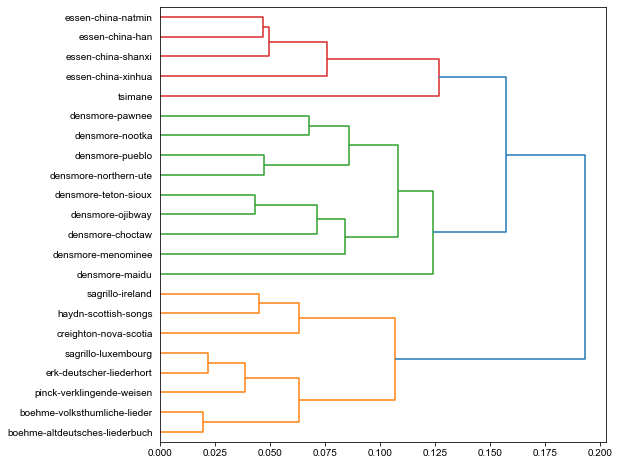

In [28]:
from scipy.spatial.distance import squareform
from scipy import cluster

plt.figure(figsize=(8, 8))
Z = cluster.hierarchy.linkage(squareform(dists), "complete")
cluster.hierarchy.dendrogram(Z, labels=CORPORA, orientation='right');
# plt.savefig('figures/melody-squares-tree.pdf')

### Group averages

In [29]:
groups = dict(
    china = [
        'essen-china-han',
        'essen-china-natmin',
        'essen-china-shanxi',
        'essen-china-xinhua',
        # 'tsimane'
    ],
    europe = [
        'boehme-altdeutsches-liederbuch',
        'boehme-volksthumliche-lieder',
        'creighton-nova-scotia',
        'erk-deutscher-liederhort',
        'haydn-scottish-songs',
        'pinck-verklingende-weisen',
        'sagrillo-ireland',
        'sagrillo-luxembourg',
    ],
    north_america = [
        'densmore-choctaw',
        'densmore-maidu',
        'densmore-menominee',
        'densmore-nootka',
        'densmore-northern-ute',
        'densmore-ojibway',
        'densmore-pawnee',
        'densmore-pueblo',
        'densmore-teton-sioux',
    ],
    all=CORPORA,
)

In [30]:
for group, corpora in groups.items():
    histograms = collect_histograms(corpora, min_value=-8, max_value=8, repeats=True)
    average = np.mean([h.values for h in histograms], axis=0)
    plt.figure(figsize=(3, 3))
    show_melodic_motif_histogram(
        average,
        norm=LogNorm(vmin=1e-3, vmax=0.15), 
    )
    plt.tight_layout()
    plt.axis('off'); plt.axis('equal')
    plt.savefig(f'figures/melody-squares-averages/melody-square-average-{group}.pdf')
    plt.close()


## Raster plots

In [31]:
def decorate_raster_plot(
        small_ax, large_ax, 
        small_color='C3', large_color='C0',
        large_label='larger interval',
        small_label='smaller interval',
    ):
    # Zero line
    small_ax.axvline(0, c='k', ls='--', lw=1)
    large_ax.axvline(0, c='k', ls='--', lw=1)

    # Ticks and labels
    large_ax.tick_params(axis='x', labelcolor=large_color)
    small_ax.tick_params(axis='x', labelcolor=small_color)
    
    # Labels
    large_ax.set_xlabel(large_label, color=large_color) 
    small_ax.set_xlabel(small_label, color=small_color) 

    # Format the spines
    for spine in ['top', 'bottom']:
        small_ax.spines[spine].set_color(small_color)
        small_ax.spines[spine].set_linewidth(2)
        large_ax.spines[spine].set_color(large_color)
        large_ax.spines[spine].set_linewidth(2)
    
    sns.despine(ax=small_ax, left=True, top=False)
    sns.despine(ax=large_ax, left=True, top=False)
    small_ax.set_yticks([])
    large_ax.set_yticks([])

In [32]:
def jitter_scatter(x, y, jitter=.1, **kwargs):
    _kwargs = dict(s=1, alpha=.5, ax=plt.gca(), lw=0)
    _kwargs.update(kwargs)
    ax = _kwargs.pop('ax')
    (xjit, yjit) = (jitter, jitter) if type(jitter) != tuple else jitter
    x += np.random.normal(0, xjit, x.shape)
    y += np.random.normal(0, yjit, y.shape)
    ax.scatter(x, y, **_kwargs)

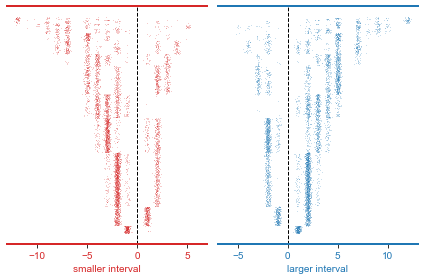

In [33]:
def show_melodic_motif_raster_plot(motifs, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharey=True, tight_layout=True)
    ax1, ax2 = axs
    decorate_raster_plot(ax1, ax2)

    size = np.abs(motifs).sum(axis=1)
    order = np.argsort(size)
    short, long = np.sort(motifs[order, :], axis=1).T

    ys = np.arange(len(short)).astype(float)
    alpha = 1 if len(motifs) < 2000 else .3
    jitter_scatter(short, ys, jitter=.15, alpha=alpha, ax=ax1, c='C3')
    jitter_scatter(long, ys, jitter=.15, alpha=alpha,  ax=ax2, c='C0')
    # ax1.set_xlim(np.quantile(short, .05), np.quantile(short, .95))
    # ax2.set_xlim(np.quantile(long, .05), np.quantile(long, .95))
    ax1.set_xlim(-13, 7)
    ax2.set_xlim(-7, 13)

_, pitches = load_data('creighton-nova-scotia', repeats=False)
motifs = interval_motifs(pitches, 2)
show_melodic_motif_raster_plot(motifs)


In [34]:
# for corpus in CORPORA:
#     _, pitches = load_data(corpus, repeats=False)
#     motifs = interval_motifs(pitches, 2)
#     show_melodic_motif_raster_plot(motifs)
#     plt.suptitle(corpus)
#     plt.savefig(f'figures/melody-raster-plots/melodic-raster-plot-{corpus}.pdf')
#     plt.close()

## Triangles after all?

Can't you make some kind of melodic triangles? The first idea is to normalize by the reach of a motif, but the problem is that a motif can also move outside the 'reach'...

In [35]:
def pitch_motifs(songs, length=3, normalize=True, sort=False):
    motifs = []
    for song in songs:
        song_motifs = sliding_window(song, length + 1)
        motifs.extend(song_motifs)
    motifs = np.array(motifs)
    if sort:
        motifs.sort(axis=1)
        
    reach = motifs[:, -1] - motifs[:, 0]
    intervals = motifs[:, 1:] - motifs[:, :-1]
    if normalize:
        intervals = intervals / reach[:, np.newaxis]
    return intervals, reach

pitch_motifs([np.array([2, 3, 5, 9]), np.array([5, -6, 7])], length=2)

(array([[ 0.33333333,  0.66666667],
        [ 0.33333333,  0.66666667],
        [-5.5       ,  6.5       ]]),
 array([3, 6, 2]))

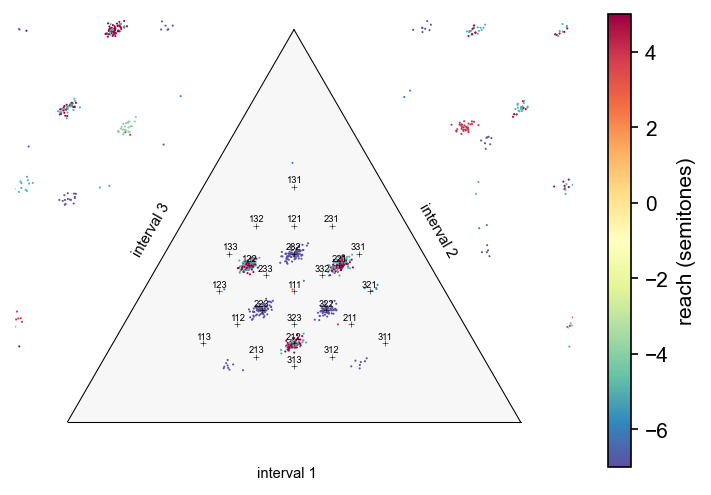

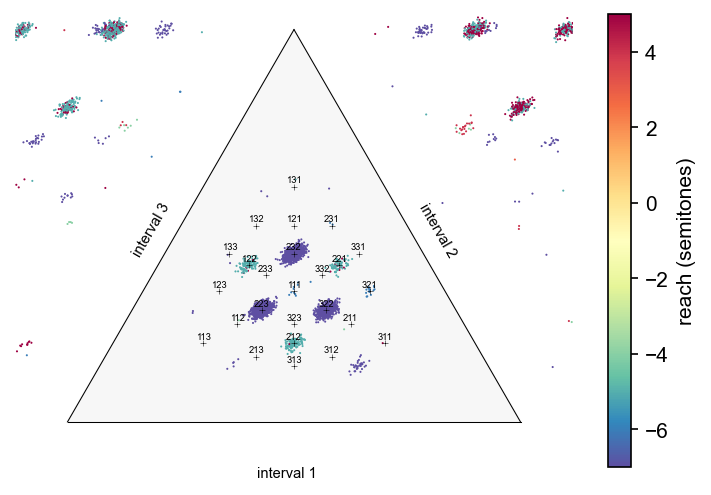

In [36]:
# corpus = 'creighton-nova-scotia'
for corpus in ['creighton-nova-scotia', 'essen-china-han']:
    _, pitches = load_data(corpus, repeats=False)
    motifs, reach = pitch_motifs(pitches, 3, normalize=False)
    non_stationary = reach != 0
    motifs = motifs[non_stationary, :]
    reach = reach[non_stationary]
    motifs = motifs / reach[:, np.newaxis]
    show_triangle_scatter(motifs, reach, jitter=.01, alpha=1, 
        cmap='Spectral_r', colorbar_label='reach (semitones)')
    plt.show() 

### Sorted pitches

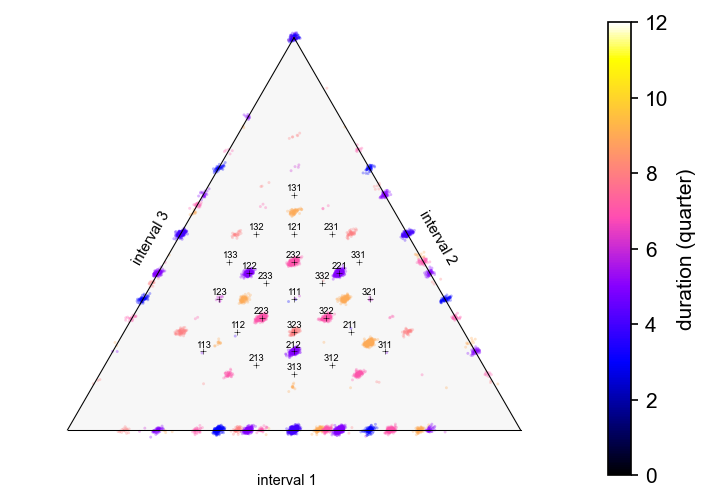

In [37]:
def show_sorted_melodic_motifs(corpus, vmin=0, vmax=12):
    _, pitches = load_data(corpus, repeats=False)
    motifs, ranges = pitch_motifs(pitches, 3, sort=True, normalize=True)
    show_triangle_scatter(motifs, ranges, jitter=.005, s=2, cmap='gnuplot2', vmin=vmin, vmax=vmax)

show_sorted_melodic_motifs('creighton-nova-scotia')

In [38]:
# for corpus in CORPORA:
#     show_sorted_melodic_motifs('creighton-nova-scotia')
#     plt.title(corpus)
#     plt.show()